In [10]:
import pandas as pd
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.model_selection import cross_val_score
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
gb_model = pickle.load(open('gradient_boost_completion_first_quarter.p', 'rb')) # load the model

In [12]:
gb_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [13]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [14]:
X_train = pd.read_csv('../data/processed/first_quarter/X_train.csv')
y_train = pd.read_csv('../data/processed/first_quarter/y_train.csv')
y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_train.fillna(value = 0, inplace = True)
X_test.fillna(value = 0, inplace = True)

In [15]:
    predictions = gb_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = gb_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

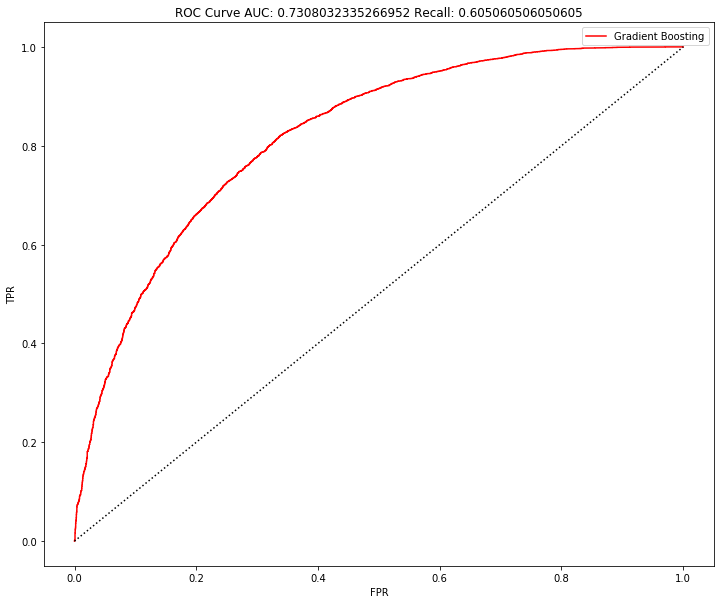

Best Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Roc Auc: 0.7308032335266952

Recall Score: 0.605060506050605

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.86      0.80      5026
        True       0.75      0.61      0.67      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.75      0.73      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix:
 [[22

In [16]:
    print_roc_curve(y_test, probas, 'Gradient Boosting')
    print('Best Model: {}'.format(gb_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [8]:
features=list(range(len(X_train.columns)))

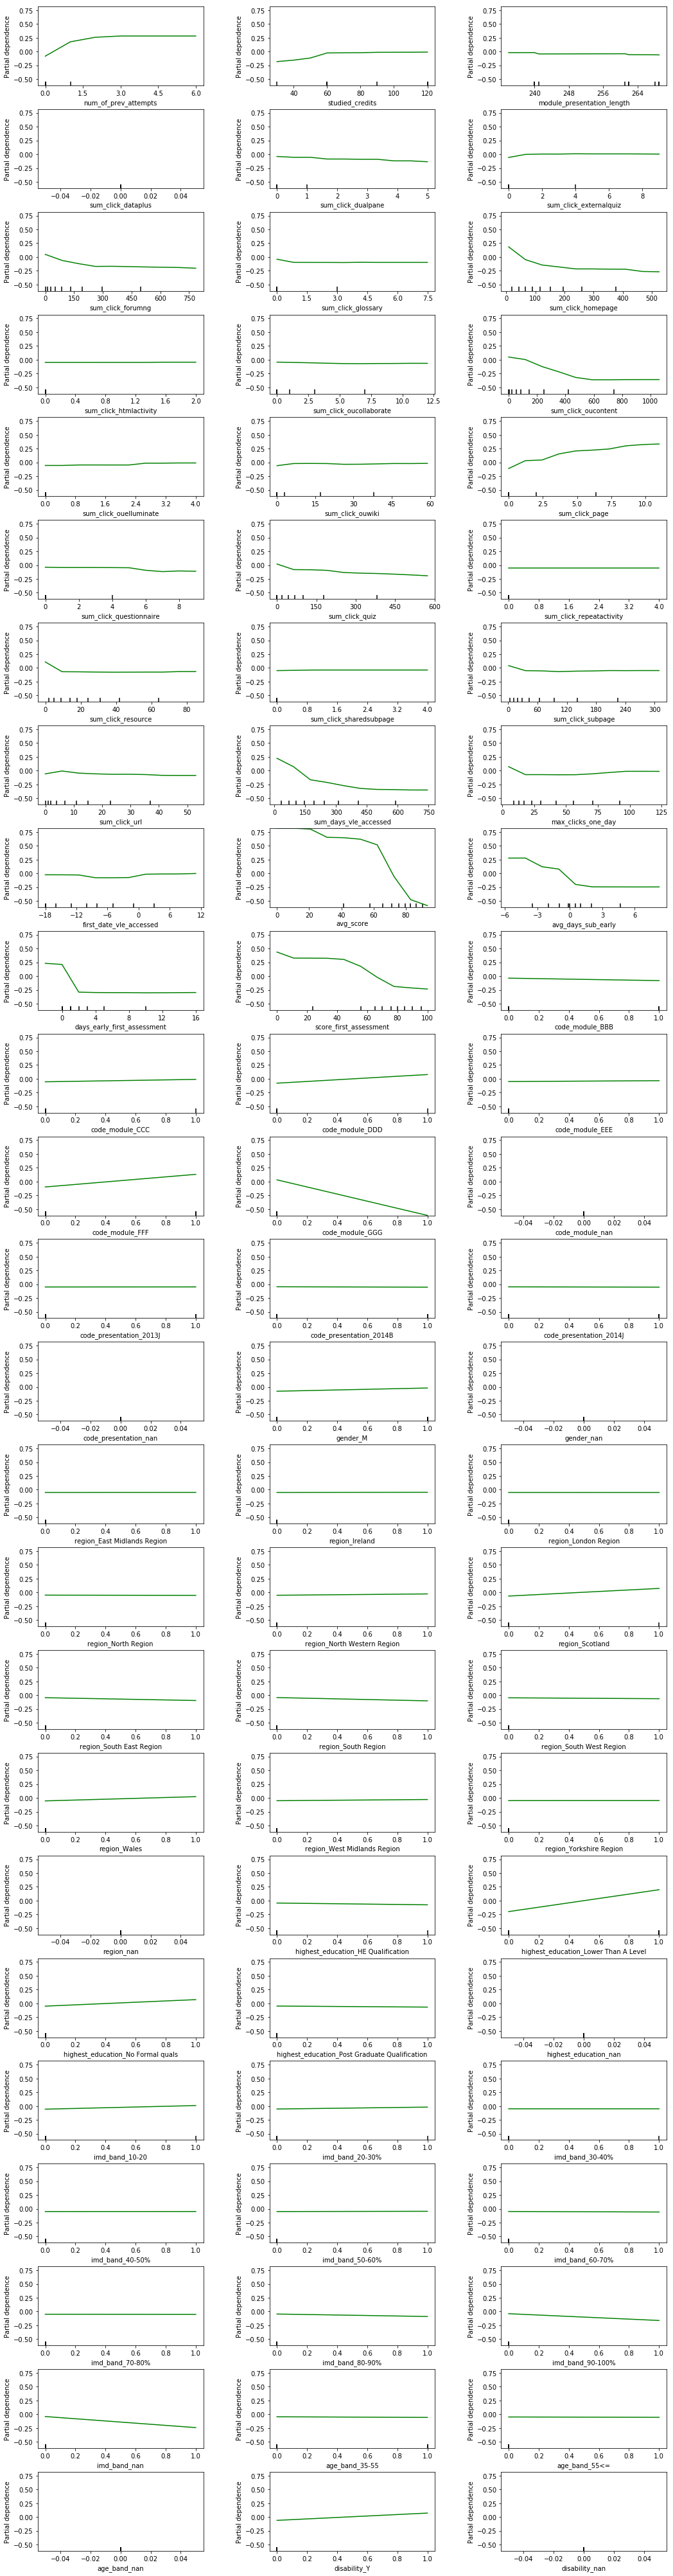

In [9]:
feat = []
for n in range(75):
    feat.append(n)
fig, ax = plot_partial_dependence(gb_model, X=X_train, features=feat, feature_names=X_train.columns[feat], grid_resolution=10)
fig.set_figwidth(16)
fig.set_figheight(100)

In [13]:
# pickle.dump(model, open('gradient_boost_completion.p', 'wb')) # save the model